# **Step 1: Check Input Data**

In [6]:
# Before start, remember to change the npy file path
# npy_file_path = "ozone_matched_with_all_meteo_features_and_LCZ_and_Pop_and_Emission_weighted_2001-2014.npy"
npy_file_path = "data/input_version_2 - 0p03grid_ozone_population_urbanfrac_road_lu_emissions_meteo_pm25_no2_v2.npy"

### 1.1 Dataset Overview


In [7]:
import numpy as np
import pandas as pd

# Load full ozone dataset with all features
data = np.load(npy_file_path, allow_pickle=True)
ozone_df = pd.DataFrame.from_records(data)

# Quick inspection
print(f"Loaded {len(ozone_df)} records with {len(ozone_df.columns)} columns:")
print(ozone_df.columns.tolist())

# Count grid points for specific year ranges
count_2001_2013 = ozone_df[ozone_df['year'].between(2001, 2012)].shape[0]
count_2013_2015 = ozone_df[ozone_df['year'].between(2013, 2015)].shape[0]

print(f"Grid points from 2001 to 2013: {count_2001_2013}")
print(f"Grid points from 2013 to 2015: {count_2013_2015}")

Loaded 8329860 records with 46 columns:
['lon', 'lat', 'year', 'month', 'ozone', 'urban_fraction', 'road_density_m', 'LCZ_0', 'LCZ_17', 'LCZ_12', 'LCZ_11', 'LCZ_14', 'LCZ_15', 'LCZ_13', 'LCZ_16', 'LCZ_6', 'LCZ_10', 'LCZ_4', 'LCZ_2', 'LCZ_3', 'LCZ_1', 'LCZ_5', 'LCZ_8', 'CO', 'SO2', 'NOx', 'PM25', 'PM10', 'TSP', 'BC', 'OC', 'BrC', 'tasmax_monmean', 'tasmax_minus_tasmax_minus_tasmin_monmean', 'pr_monmean', 'huss_monmean', 'rel_humid_max_monmean', 'rel_humid_min_monmean', 'rsds_monmean', 'uas_monmean', 'vas_monmean', 'windspeed_monmean', 'tasmax_minus_tasmin_monmean', 'pm25_concentration', 'no2_concentration', 'population']
Grid points from 2001 to 2013: 6663888
Grid points from 2013 to 2015: 1110648


### 1.2 Outlier Detection and Distribution Visualization

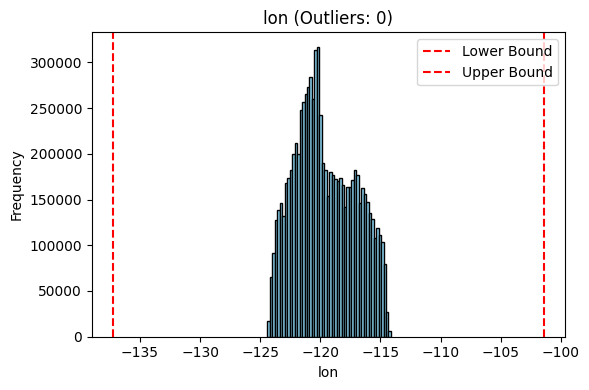

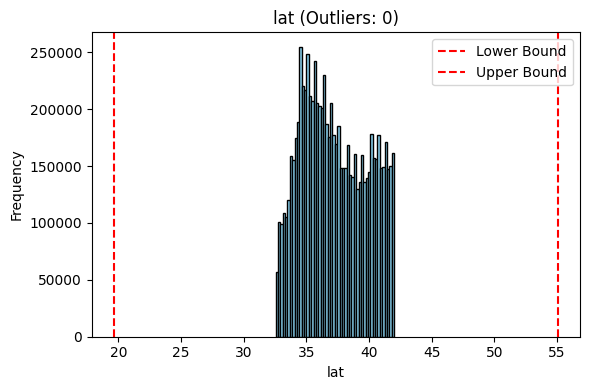

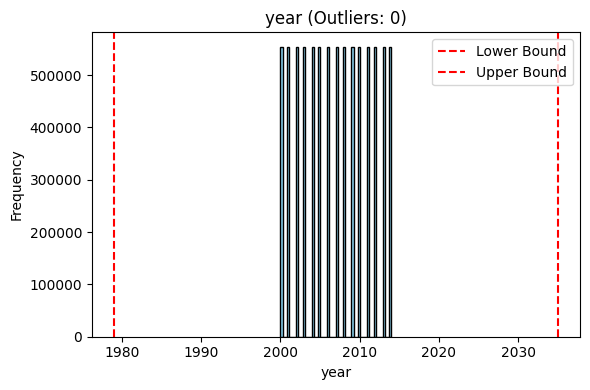

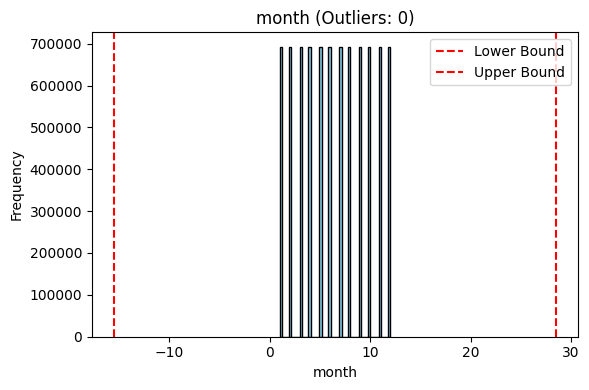

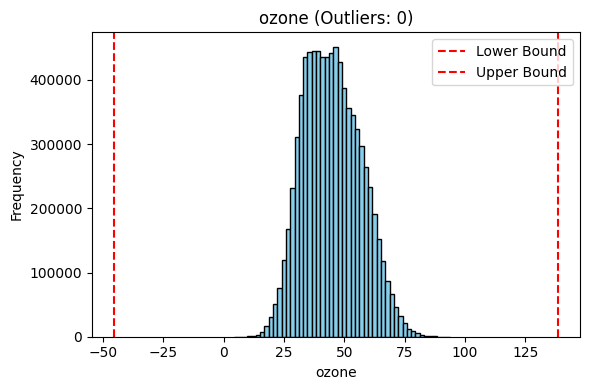

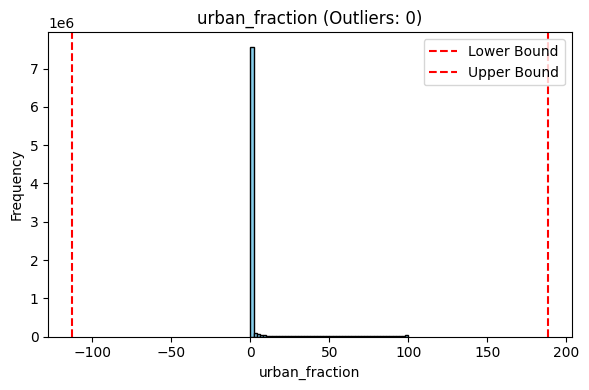

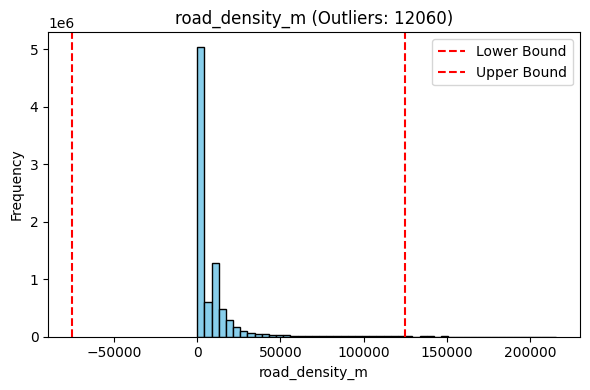

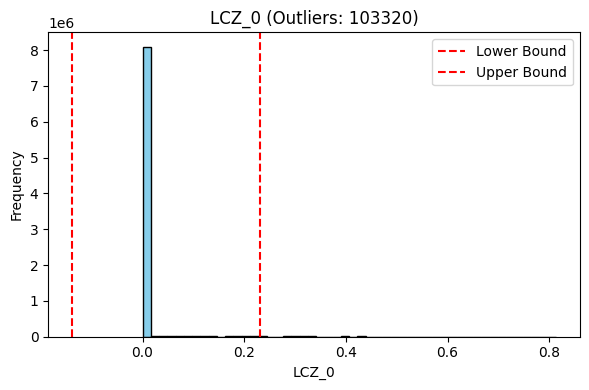

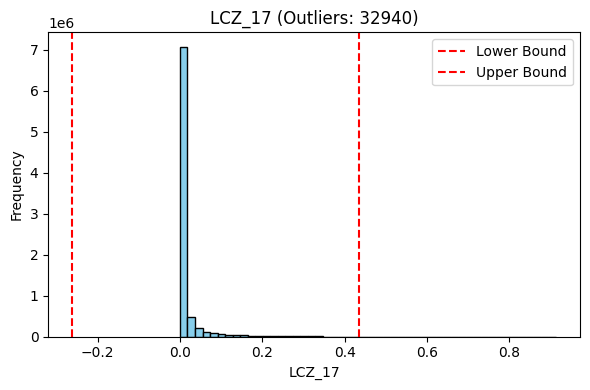

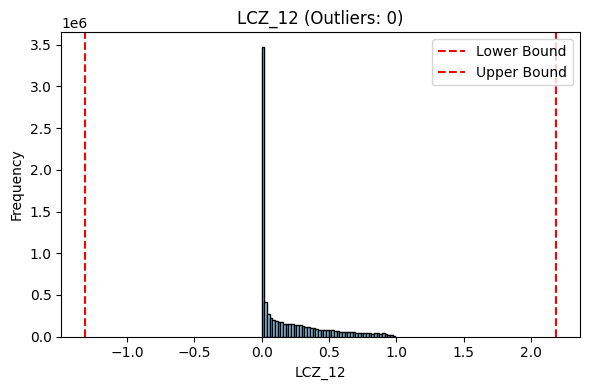

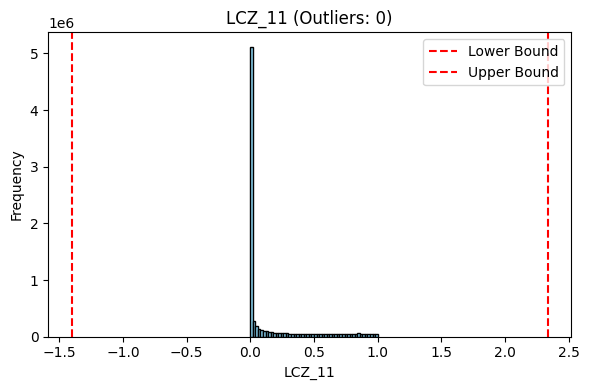

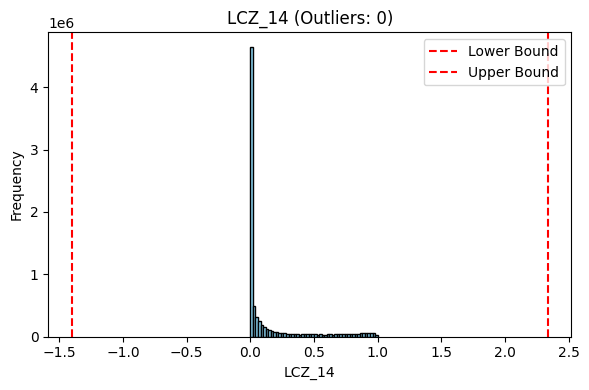

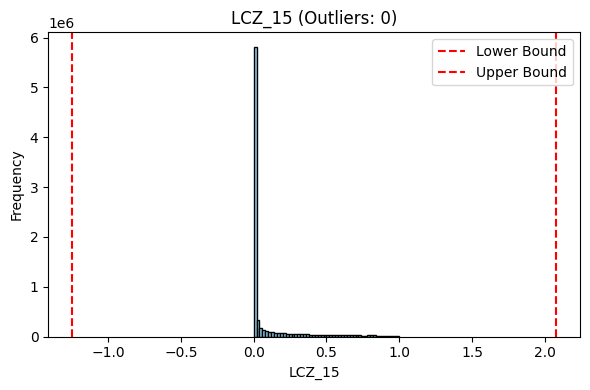

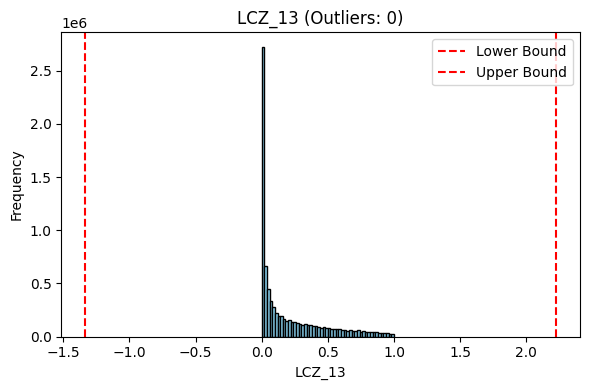

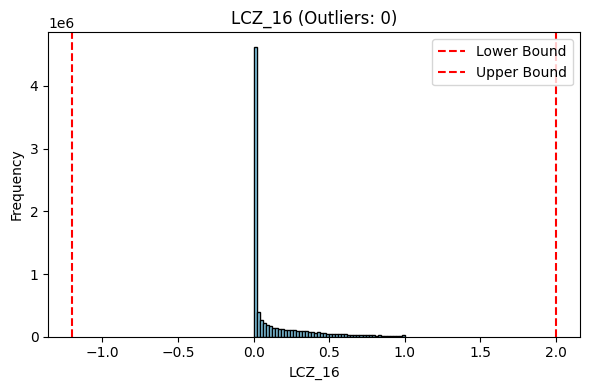

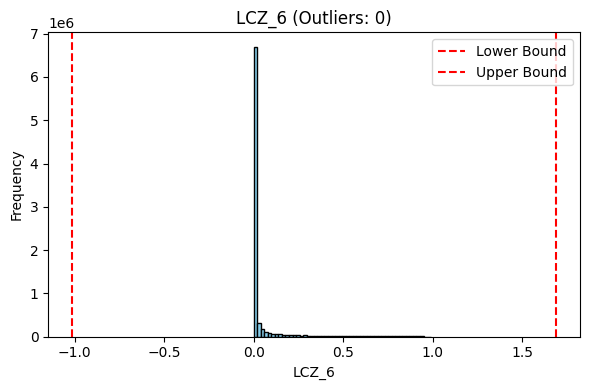

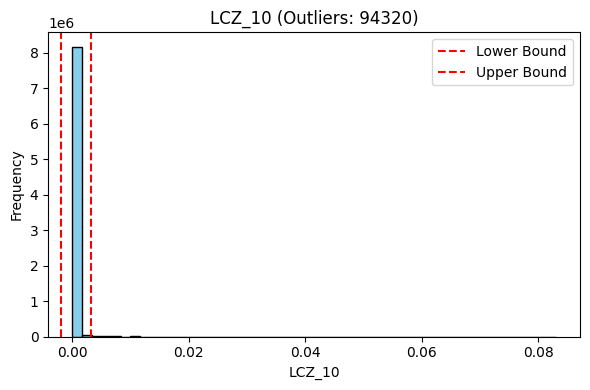

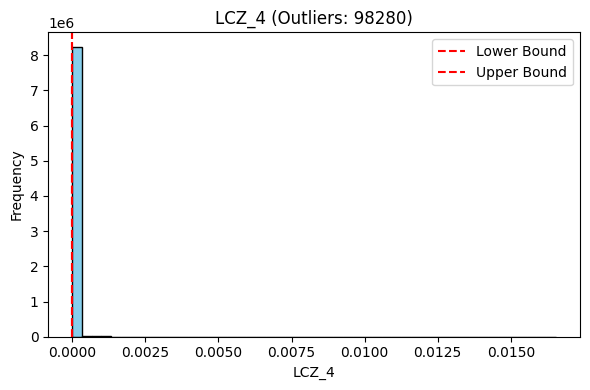

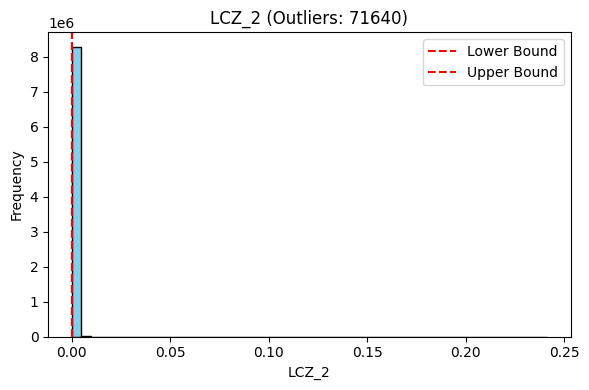

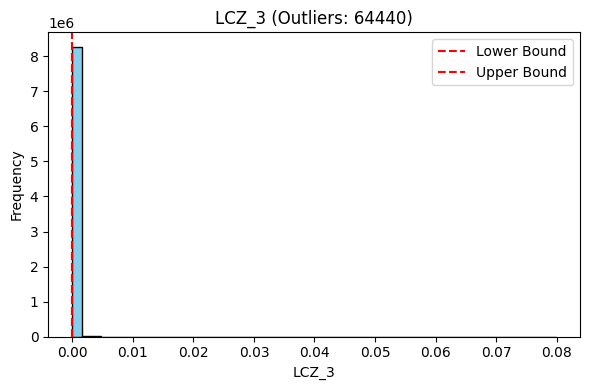

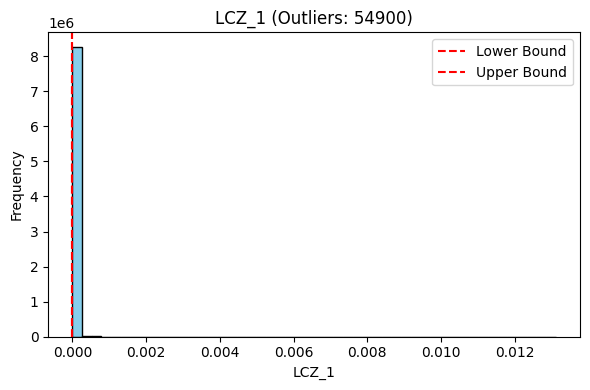

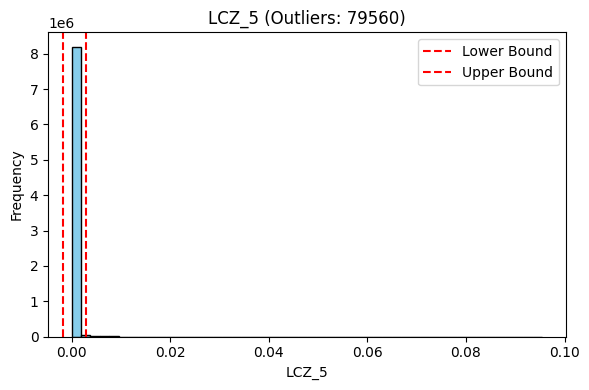

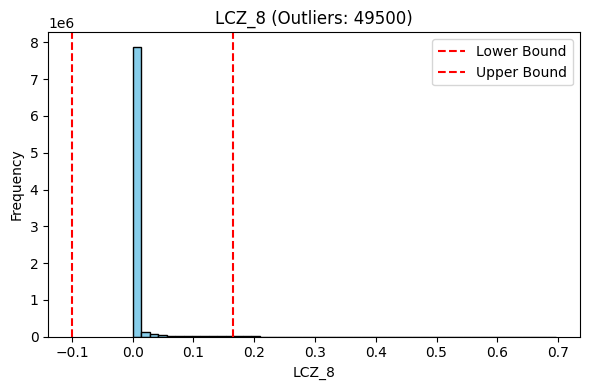

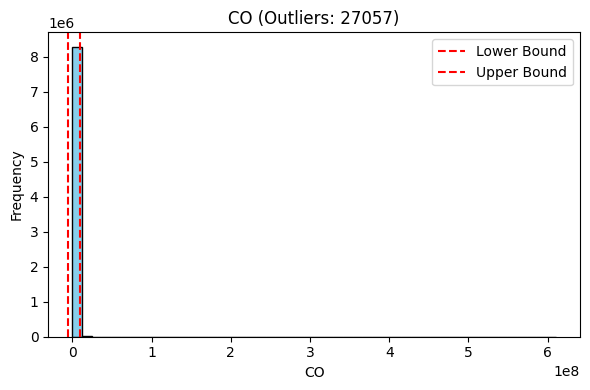

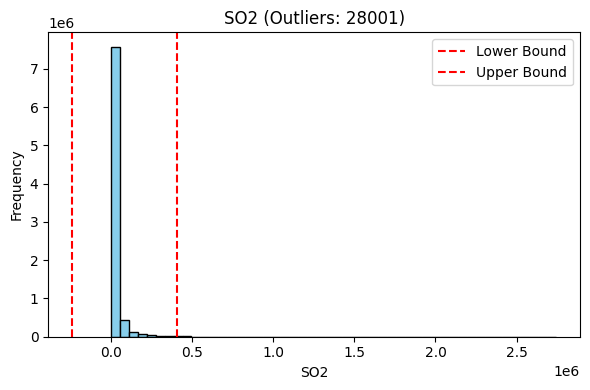

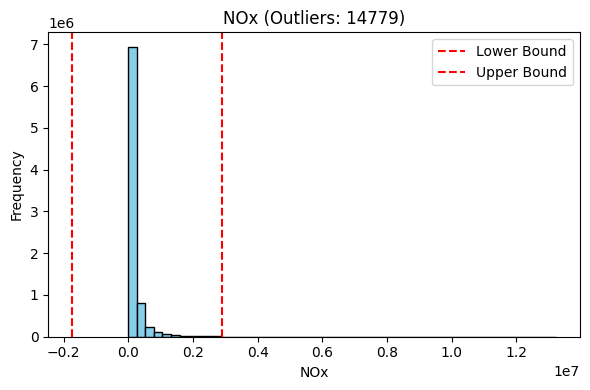

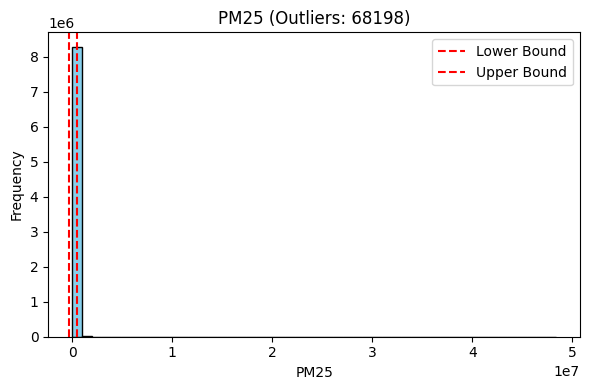

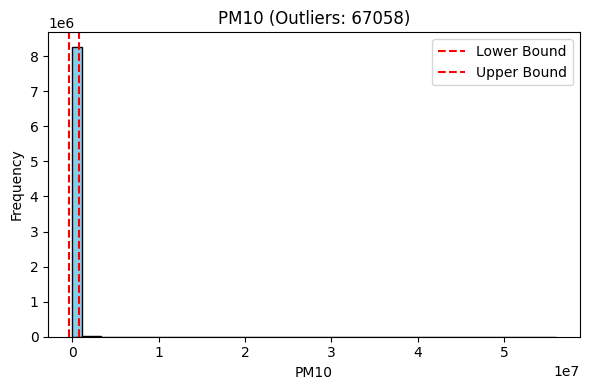

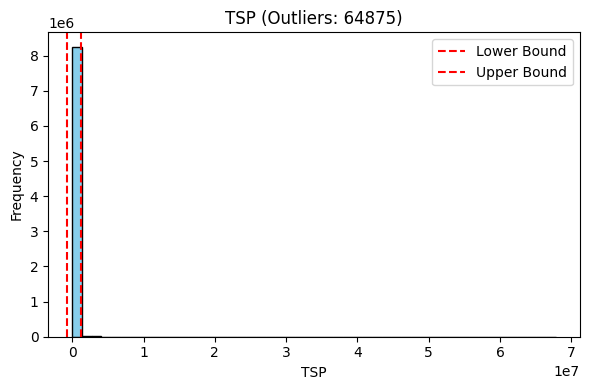

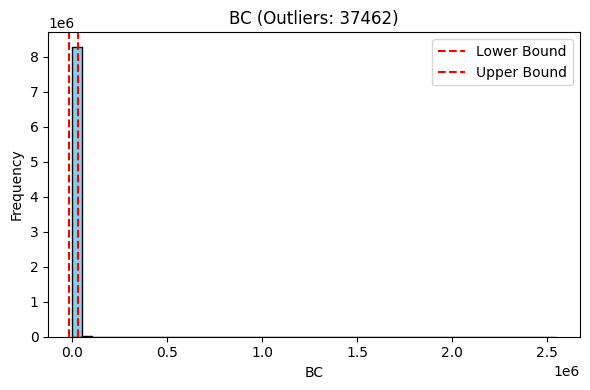

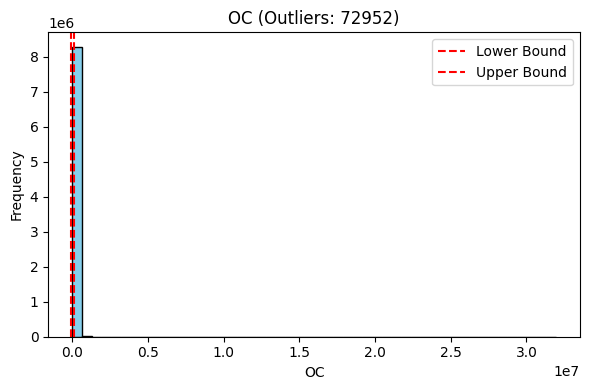

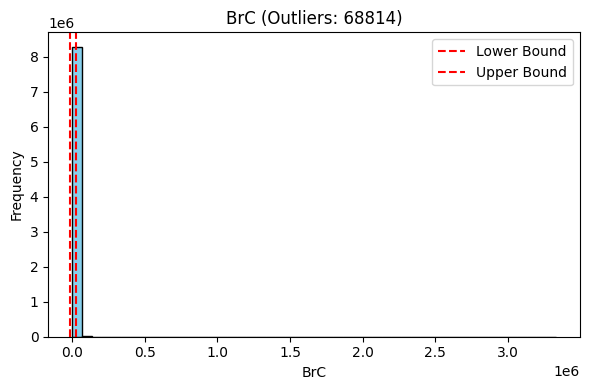

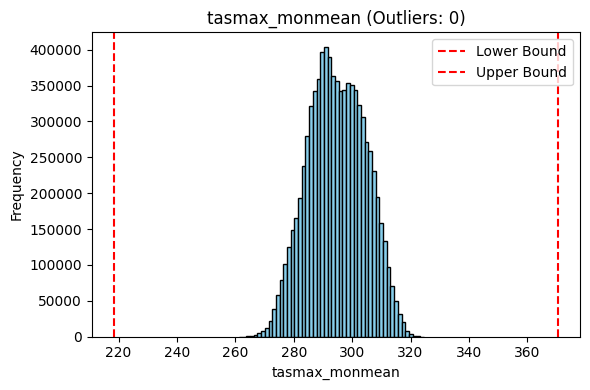

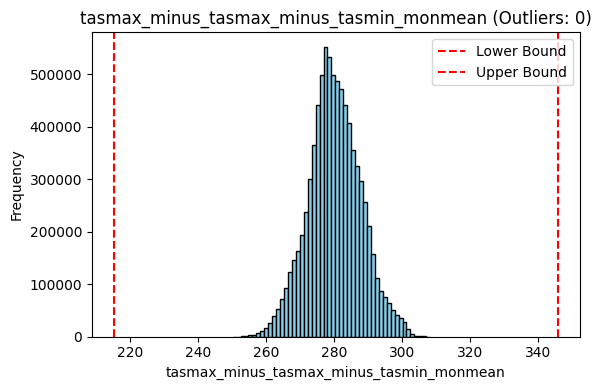

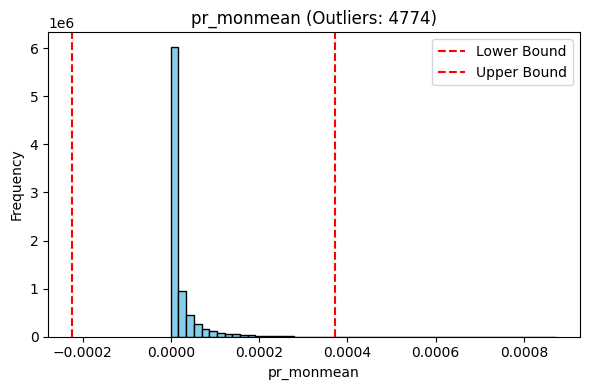

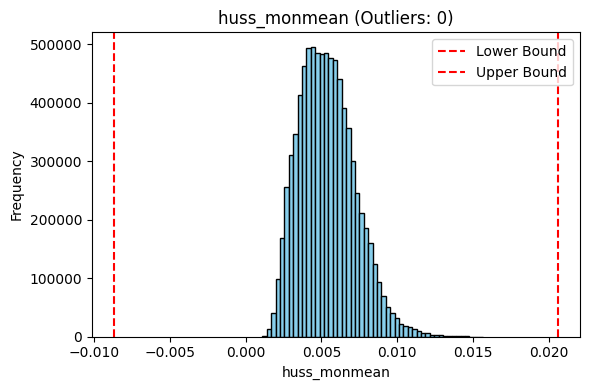

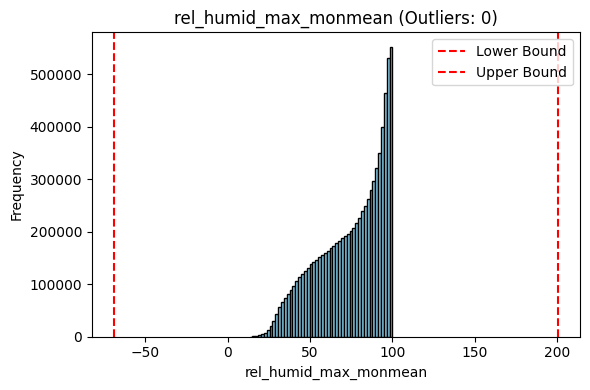

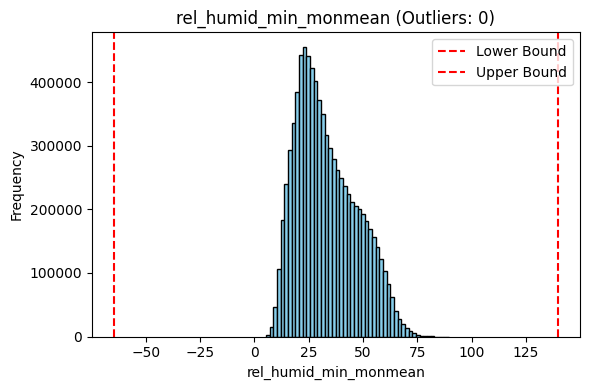

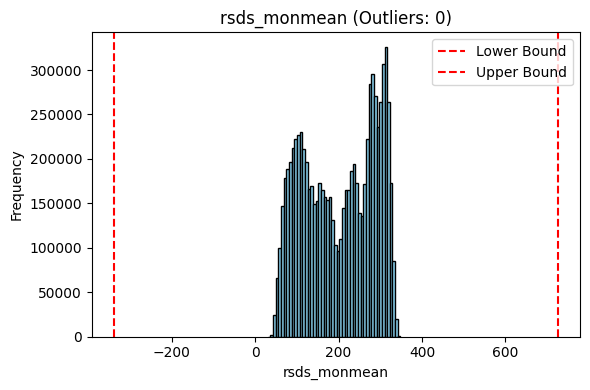

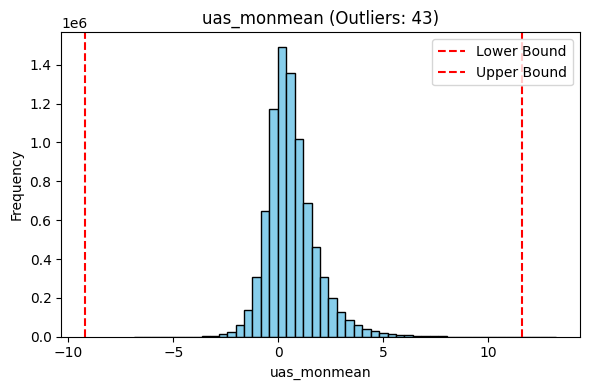

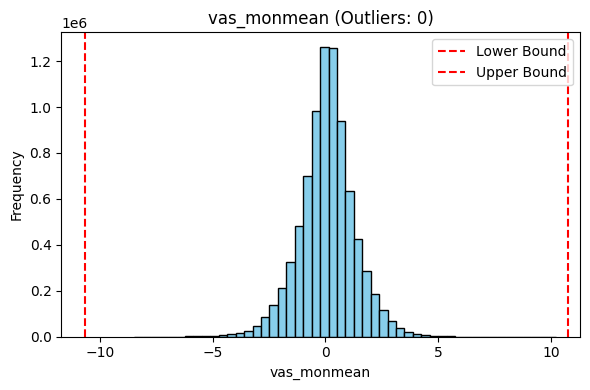

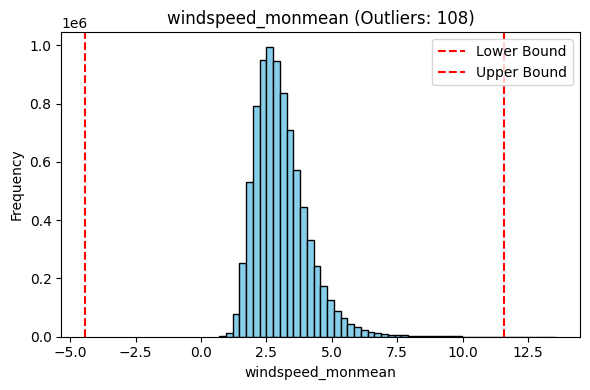

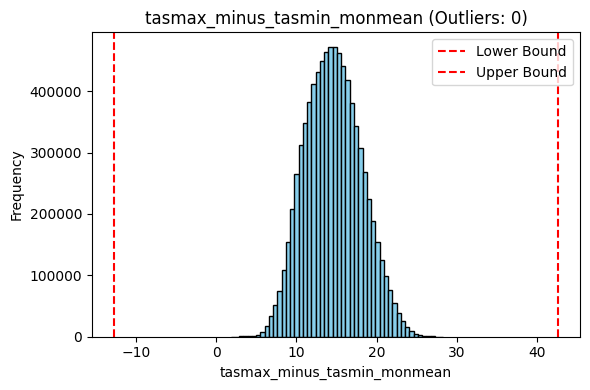

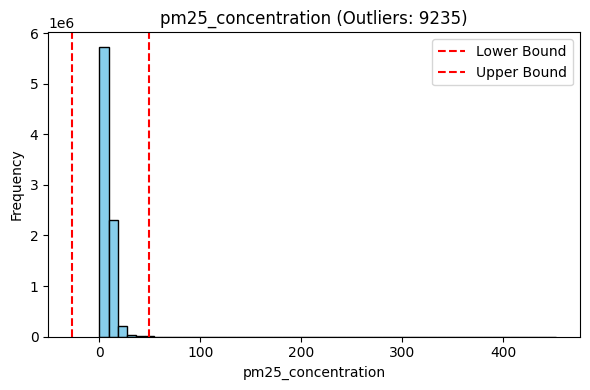

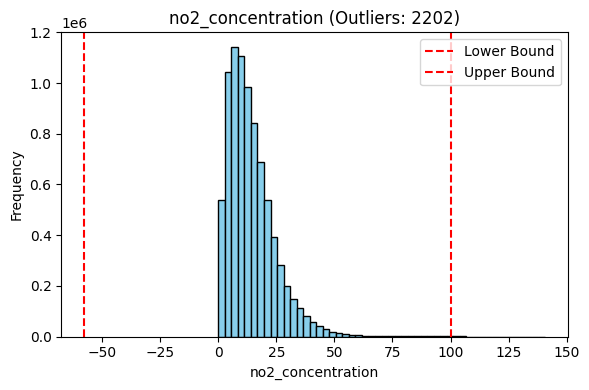

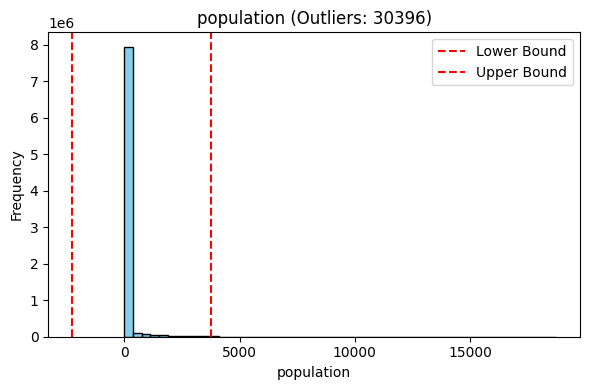

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load data
data = np.load(npy_file_path, allow_pickle=True)
df = pd.DataFrame.from_records(data)

# Keep only numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Remove rows with NaN values or non-positive ozone values
df = df.dropna()
df = df[df["ozone"] > 0]

# Plot histograms for each variable and indicate extreme value thresholds (using IQR method)
for col in numeric_cols:
    values = df[col]
    Q1 = values.quantile(0.02)
    Q3 = values.quantile(0.98)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outlier_count = ((values < lower_bound) | (values > upper_bound)).sum()

    plt.figure(figsize=(6, 4))
    plt.hist(values, bins=50, color='skyblue', edgecolor='black')
    plt.axvline(lower_bound, color='red', linestyle='--', label='Lower Bound')
    plt.axvline(upper_bound, color='red', linestyle='--', label='Upper Bound')
    plt.title(f"{col} (Outliers: {outlier_count})")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()

# **Step 2: Prepare data**

### 2.1 Predict Ozone

In [9]:
!pip install xgboost pykrige

  Using cached xgboost-3.0.2-py3-none-macosx_12_0_arm64.whl (2.0 MB)
  Using cached PyKrige-1.7.2-cp310-cp310-macosx_11_0_arm64.whl (212 kB)

[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid, train_test_split
from tqdm import tqdm, trange
from sklearn.model_selection import KFold
from pykrige.ok import OrdinaryKriging # newly added
import os

# ---------------------------
# Load and clean data
# ---------------------------
data = np.load(npy_file_path, allow_pickle=True)
df = pd.DataFrame.from_records(data)

df = df.dropna()
df = df[df["ozone"] > 0]

df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12.0)
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12.0)

# ---------------------------
# Update feature columns (exclude target and non-input columns)
# ---------------------------
drop_cols = ["ozone", "year", "month"]
feature_cols = [col for col in df.select_dtypes(include=[np.number]).columns if col not in drop_cols]

# ---------------------------
# Split training, residual, and test datasets by year
# ---------------------------
train_df = df[df["year"].isin(range(2001, 2013))]   # For model training
test_df  = df[df["year"].isin(range(2013, 2015))]   # For final testing

# Full training data
X_train_full = train_df[feature_cols]
y_train_full = train_df["ozone"]

# Hold out 20% of training set for validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Final test set
X_test = test_df[feature_cols]
y_test = test_df["ozone"]

### 2.2 Predict Ozone，PM25_concentration，NO2_concentration

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid, train_test_split
from tqdm import tqdm, trange
from sklearn.model_selection import KFold
from pykrige.ok import OrdinaryKriging # newly added
import os

def prepare_xgb_data(target_name):
    """
    Loads data, processes features, splits train/val/test by year, and returns datasets.

    Parameters:
        target_name (str): One of ['ozone', 'pm25_concentration', 'no2_concentration']

    Returns:
        X_train, X_val, y_train, y_val, X_test, y_test, feature_cols
    """
    data = np.load(npy_file_path, allow_pickle=True)
    df = pd.DataFrame.from_records(data)

    df = df.dropna()
    df = df[df[target_name] > 0]  # Optional filtering for valid target values

    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12.0)
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12.0)

    # Drop target variables + year/month
    drop_cols = ["year", "month", "ozone", "pm25_concentration", "no2_concentration"]
    feature_cols = [col for col in df.select_dtypes(include=[np.number]).columns if col not in drop_cols]

    train_df = df[df["year"].isin(range(2001, 2013))]
    test_df  = df[df["year"].isin(range(2013, 2015))]

    X_train_full = train_df[feature_cols]
    y_train_full = train_df[target_name]
    X_test = test_df[feature_cols]
    y_test = test_df[target_name]

    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=0.2, random_state=42
    )

    return X_train, X_val, y_train, y_val, X_test, y_test, feature_cols


## **Step 3: Training Model**

### 3.1 Baseline XGBoost Model

Total parameter combinations to try: 1
Starting 5-fold cross-validation...


Parameter Set:   0%|          | 0/1 [00:00<?, ?it/s]/Users/freddy/Documents/ACE Lab/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:50:56] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)
/Users/freddy/Documents/ACE Lab/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:51:40] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)
/Users/freddy/Documents/ACE Lab/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:52:24] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)
/Users/freddy/Documents/ACE Lab/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:53:11] WARNING: /Users/runner/work/xgboost

>>> New best found! RMSE: 2.0771, Params: {'colsample_bytree': 0.5, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 5, 'n_estimators': 200, 'reg_alpha': 0.0, 'reg_lambda': 0.01, 'subsample': 0.8}

===== Final Evaluation Metrics =====
Best CV Mean RMSE:       2.0771
Best CV Mean R²:         0.9699
Validation RMSE:         2.0799
Validation R²:           0.9698
Validation Mean Bias:    -0.0002
Test RMSE:               4.0762
Test R²:                 0.8416
Test Mean Bias:          -0.1505
Best parameters: {'colsample_bytree': 0.5, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 5, 'n_estimators': 200, 'reg_alpha': 0.0, 'reg_lambda': 0.01, 'subsample': 0.8}


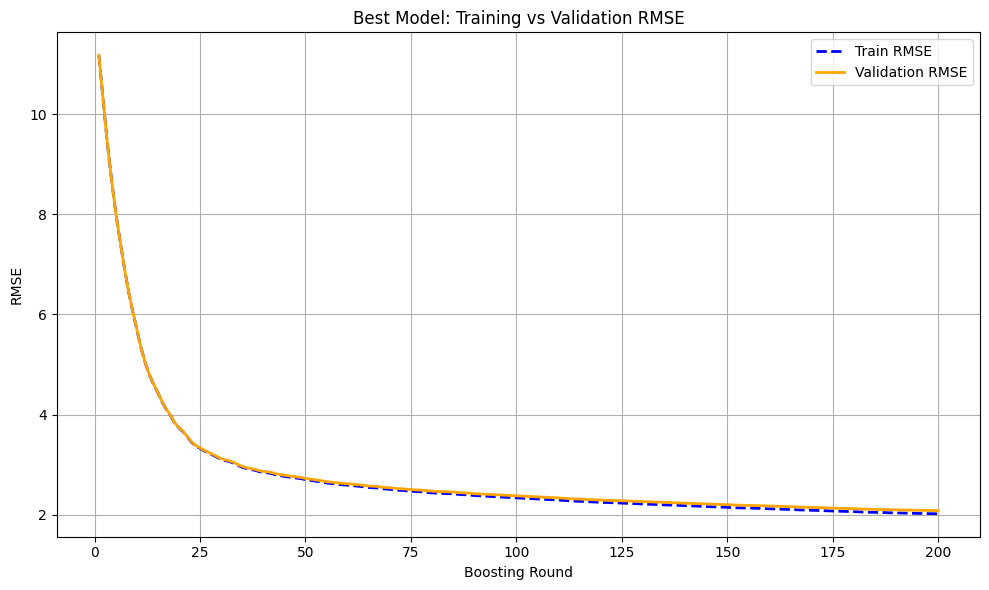

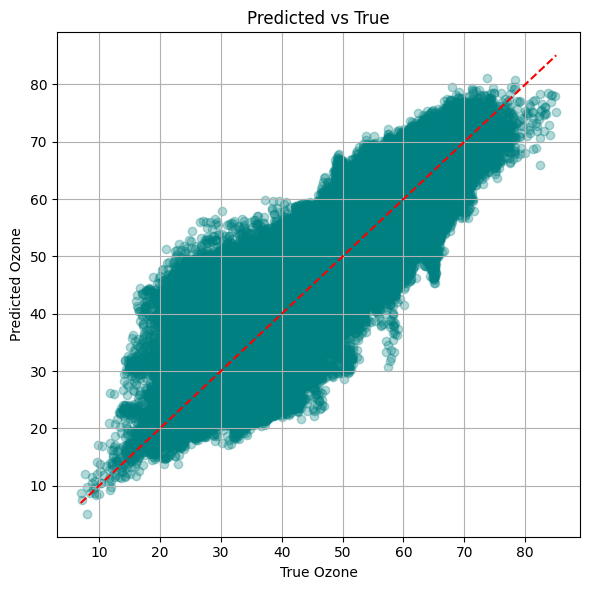

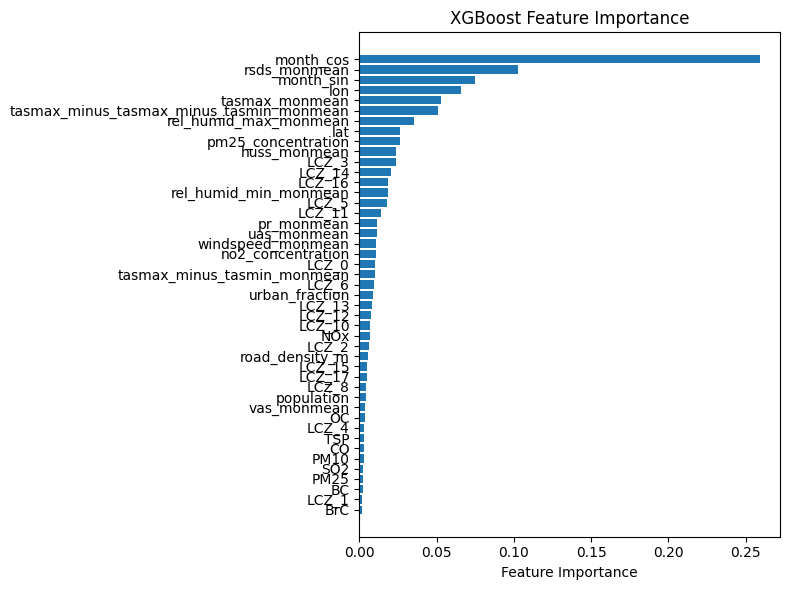

In [12]:
from sklearn.model_selection import KFold

# ---------------------------
# Grid search parameter settings (small range)
# ---------------------------
param_grid = {
    "n_estimators": [200],
    "max_depth": [10],
    "min_child_weight": [5],
    "learning_rate": [0.1],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
    "reg_alpha": [0.0],
    "reg_lambda": [0.01],
    "gamma": [0.1]
}

grid = list(ParameterGrid(param_grid))
print("Total parameter combinations to try:", len(grid))

# ---------------------------
# Grid search with progress bar
# ---------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_score = float("inf")
best_model = None
best_result_idx = None
best_y_test_pred = None
results_list = []

print("Starting 5-fold cross-validation...")

for param_idx, params in enumerate(tqdm(grid, desc="Parameter Set")):
    fold_rmse_list = []
    fold_r2_list = []

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        X_tr, X_va = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_va = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = XGBRegressor(
            tree_method="hist",
            device="cuda",
            random_state=42,
            eval_metric="rmse",
            n_jobs=-1,
            **params
        )

        model.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_va, y_va)], verbose=False)

        y_va_pred = model.predict(X_va)
        rmse = np.sqrt(mean_squared_error(y_va, y_va_pred))
        r2 = r2_score(y_va, y_va_pred)
        fold_rmse_list.append(rmse)
        fold_r2_list.append(r2)

    # Average performance for each parameter set
    mean_rmse = np.mean(fold_rmse_list)
    mean_r2 = np.mean(fold_r2_list)

    # Retrain the model on the full training set
    final_model = XGBRegressor(
        tree_method="hist",
        device="cuda",
        random_state=42,
        eval_metric="rmse",
        n_jobs=-1,
        **params
    )
    final_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=False)

    # Evaluate the final model on validation and test sets
    y_val_pred = final_model.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_r2 = r2_score(y_val, y_val_pred)
    val_mb = np.mean(y_val_pred - y_val)

    y_test_pred = final_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)
    test_mb = np.mean(y_test_pred - y_test)

    results_list.append({
        "params": params,
        "cv_mean_rmse": mean_rmse,
        "cv_mean_r2": mean_r2,
        "val_rmse": val_rmse,
        "val_r2": val_r2,
        "val_mb": val_mb,
        "test_rmse": test_rmse,
        "test_r2": test_r2,
        "test_mb": test_mb
    })

    if mean_rmse < best_score:
        best_score = mean_rmse
        best_result_idx = len(results_list) - 1
        best_model = final_model
        best_y_test_pred = y_test_pred
        print(f">>> New best found! RMSE: {mean_rmse:.4f}, Params: {params}")


# ---------------------------
# Output all results
# ---------------------------
best_result = results_list[best_result_idx]
print("\n===== Final Evaluation Metrics =====")
print(f"Best CV Mean RMSE:       {best_result['cv_mean_rmse']:.4f}")
print(f"Best CV Mean R²:         {best_result['cv_mean_r2']:.4f}")
print(f"Validation RMSE:         {best_result['val_rmse']:.4f}")
print(f"Validation R²:           {best_result['val_r2']:.4f}")
print(f"Validation Mean Bias:    {best_result['val_mb']:.4f}")
print(f"Test RMSE:               {best_result['test_rmse']:.4f}")
print(f"Test R²:                 {best_result['test_r2']:.4f}")
print(f"Test Mean Bias:          {best_result['test_mb']:.4f}")
print("Best parameters:", best_result["params"])

# Save the best model to file 
os.makedirs("Trained Model", exist_ok=True)
best_model.save_model("Trained Model/best_xgb_model_v10086.json")

# ---------------------------
# Plot training curve of the best model
# ---------------------------
results = best_model.evals_result_
train_rmse = results['validation_0']['rmse']
val_rmse = results['validation_1']['rmse']
rounds = list(range(1, len(train_rmse) + 1))

plt.figure(figsize=(10, 6))
plt.plot(rounds, train_rmse, label='Train RMSE', linewidth=2, linestyle='--', color='blue')
plt.plot(rounds, val_rmse, label='Validation RMSE', linewidth=2, linestyle='-', color='orange')
plt.xlabel("Boosting Round")
plt.ylabel("RMSE")
plt.title("Best Model: Training vs Validation RMSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred, alpha=0.3, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Ozone")
plt.ylabel("Predicted Ozone")
plt.title("Predicted vs True")
plt.grid(True)
plt.tight_layout()
plt.show()

importances = best_model.feature_importances_
features = X_train.columns

plt.figure(figsize=(8, 6))
sorted_idx = np.argsort(importances)
plt.barh(range(len(importances)), importances[sorted_idx], align='center')
plt.yticks(range(len(importances)), features[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()


### 3.2 XGBoost Model for ozone，pm25_concentration，no2_concentration

Total parameter combinations to try: 1
Starting 5-fold cross-validation...


Parameter Set:   0%|          | 0/1 [00:00<?, ?it/s]/Users/freddy/Documents/ACE Lab/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:02:38] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)
/Users/freddy/Documents/ACE Lab/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:03:16] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)
/Users/freddy/Documents/ACE Lab/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:04:09] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)
/Users/freddy/Documents/ACE Lab/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:04:48] WARNING: /Users/runner/work/xgboost

>>> New best found! RMSE: 1.7210, Params: {'colsample_bytree': 0.5, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 5, 'n_estimators': 200, 'reg_alpha': 0.0, 'reg_lambda': 0.01, 'subsample': 0.8}

===== Final Evaluation Metrics =====
Best CV Mean RMSE:       1.7210
Best CV Mean R²:         0.9049
Validation RMSE:         1.6989
Validation R²:           0.9121
Validation Mean Bias:    -0.0043
Test RMSE:               6.0845
Test R²:                 0.5071
Test Mean Bias:          -0.0506
Best parameters: {'colsample_bytree': 0.5, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 5, 'n_estimators': 200, 'reg_alpha': 0.0, 'reg_lambda': 0.01, 'subsample': 0.8}


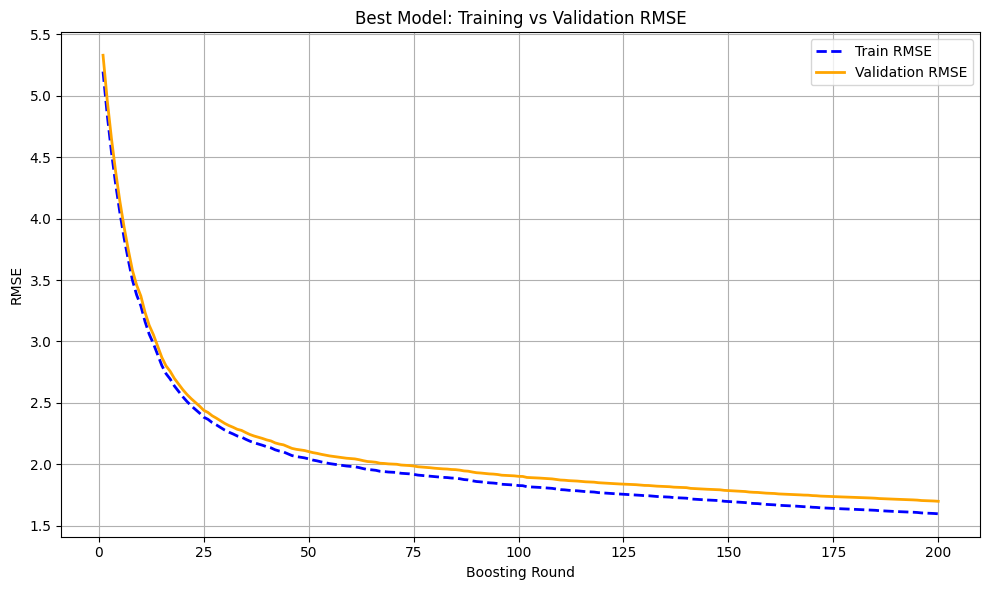

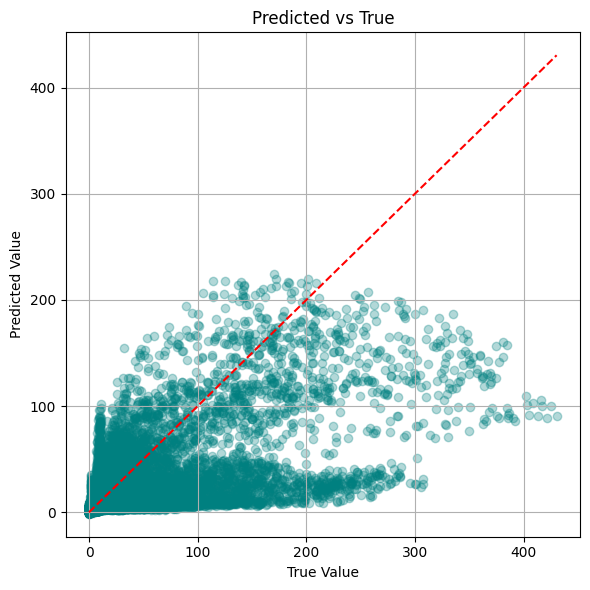

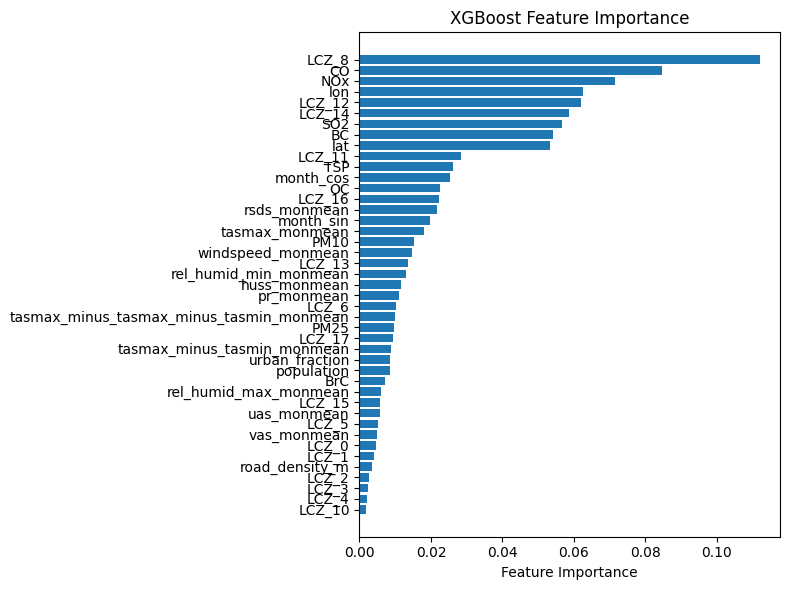

In [16]:
from sklearn.model_selection import KFold

# ---------------------------
# Set target variable (manually switch here)
# ---------------------------
target_name = "pm25_concentration"  # ['ozone', 'pm25_concentration', 'no2_concentration']
X_train, X_val, y_train, y_val, X_test, y_test, feature_cols = prepare_xgb_data(
    target_name=target_name,
)

# ---------------------------
# Grid search parameter settings (small range)
# ---------------------------
param_grid = {
    "n_estimators": [200],
    "max_depth": [10],
    "min_child_weight": [5],
    "learning_rate": [0.1],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
    "reg_alpha": [0.0],
    "reg_lambda": [0.01],
    "gamma": [0.1]
}

grid = list(ParameterGrid(param_grid))
print("Total parameter combinations to try:", len(grid))

# ---------------------------
# Grid search with progress bar
# ---------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_score = float("inf")
best_model = None
best_result_idx = None
best_y_test_pred = None
results_list = []

print("Starting 5-fold cross-validation...")

for param_idx, params in enumerate(tqdm(grid, desc="Parameter Set")):
    fold_rmse_list = []
    fold_r2_list = []

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        X_tr, X_va = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_va = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = XGBRegressor(
            tree_method="hist",
            device="cuda",
            random_state=42,
            eval_metric="rmse",
            n_jobs=-1,
            **params
        )

        model.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_va, y_va)], verbose=False)

        y_va_pred = model.predict(X_va)
        rmse = np.sqrt(mean_squared_error(y_va, y_va_pred))
        r2 = r2_score(y_va, y_va_pred)
        fold_rmse_list.append(rmse)
        fold_r2_list.append(r2)

    # Average performance for each parameter set
    mean_rmse = np.mean(fold_rmse_list)
    mean_r2 = np.mean(fold_r2_list)

    # Retrain the model on the full training set
    final_model = XGBRegressor(
        tree_method="hist",
        device="cuda",
        random_state=42,
        eval_metric="rmse",
        n_jobs=-1,
        **params
    )
    final_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=False)

    # Evaluate the final model on validation and test sets
    y_val_pred = final_model.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_r2 = r2_score(y_val, y_val_pred)
    val_mb = np.mean(y_val_pred - y_val)

    y_test_pred = final_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)
    test_mb = np.mean(y_test_pred - y_test)

    results_list.append({
        "params": params,
        "cv_mean_rmse": mean_rmse,
        "cv_mean_r2": mean_r2,
        "val_rmse": val_rmse,
        "val_r2": val_r2,
        "val_mb": val_mb,
        "test_rmse": test_rmse,
        "test_r2": test_r2,
        "test_mb": test_mb
    })

    if mean_rmse < best_score:
        best_score = mean_rmse
        best_result_idx = len(results_list) - 1
        best_model = final_model
        best_y_test_pred = y_test_pred
        print(f">>> New best found! RMSE: {mean_rmse:.4f}, Params: {params}")


# ---------------------------
# Output all results
# ---------------------------
best_result = results_list[best_result_idx]
print("\n===== Final Evaluation Metrics =====")
print(f"Best CV Mean RMSE:       {best_result['cv_mean_rmse']:.4f}")
print(f"Best CV Mean R²:         {best_result['cv_mean_r2']:.4f}")
print(f"Validation RMSE:         {best_result['val_rmse']:.4f}")
print(f"Validation R²:           {best_result['val_r2']:.4f}")
print(f"Validation Mean Bias:    {best_result['val_mb']:.4f}")
print(f"Test RMSE:               {best_result['test_rmse']:.4f}")
print(f"Test R²:                 {best_result['test_r2']:.4f}")
print(f"Test Mean Bias:          {best_result['test_mb']:.4f}")
print("Best parameters:", best_result["params"])

# Save the best model to file 
os.makedirs("Trained Model", exist_ok=True)
best_model.save_model("Trained Model/best_xgb_model_v10086.json")

# ---------------------------
# Plot training curve of the best model
# ---------------------------
results = best_model.evals_result_
train_rmse = results['validation_0']['rmse']
val_rmse = results['validation_1']['rmse']
rounds = list(range(1, len(train_rmse) + 1))

plt.figure(figsize=(10, 6))
plt.plot(rounds, train_rmse, label='Train RMSE', linewidth=2, linestyle='--', color='blue')
plt.plot(rounds, val_rmse, label='Validation RMSE', linewidth=2, linestyle='-', color='orange')
plt.xlabel("Boosting Round")
plt.ylabel("RMSE")
plt.title("Best Model: Training vs Validation RMSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred, alpha=0.3, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Value")
plt.ylabel("Predicted Value")
plt.title("Predicted vs True")
plt.grid(True)
plt.tight_layout()
plt.show()

importances = best_model.feature_importances_
features = X_train.columns

plt.figure(figsize=(8, 6))
sorted_idx = np.argsort(importances)
plt.barh(range(len(importances)), importances[sorted_idx], align='center')
plt.yticks(range(len(importances)), features[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()

### 3.3 Trying Residual Kriging

Evaluation on Sampled 5000 Points:
Metric                Before Kriging   After Kriging     Improvement
-----------------------------------------------------------------
RMSE                          4.9502          0.8272          4.1231
R2                            0.4832          0.9856          0.5024
Mean Bias                     0.1774         -0.0216         -0.1989


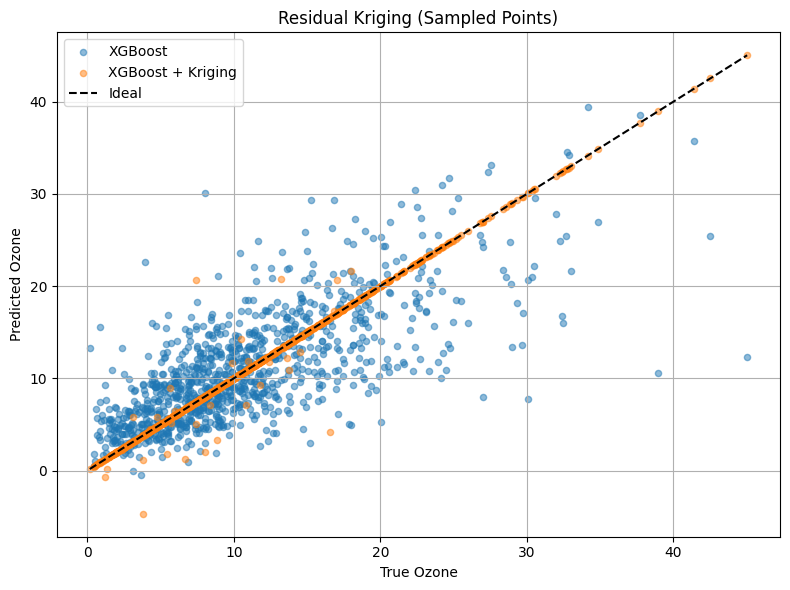

In [14]:
from pykrige.ok import OrdinaryKriging
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def sample_and_apply_kriging(y_true, y_pred, coords_df, sample_size=1000):
    """Randomly sample test points and apply Residual Kriging and compare before/after metrics."""
    # Step 1: Random sampling
    idx = np.random.choice(len(y_true), size=sample_size, replace=False)
    y_sample = y_true.iloc[idx]
    y_pred_sample = y_pred[idx]
    coords_sample = coords_df.iloc[idx]

    # Step 2: Compute residuals
    residuals = y_sample - y_pred_sample
    lats = coords_sample['lat'].values
    lons = coords_sample['lon'].values

    # Step 3: Kriging on residuals
    ok = OrdinaryKriging(
        lons, lats, residuals.values,
        variogram_model="linear",
        verbose=False,
        enable_plotting=False
    )
    kriged_residuals, _ = ok.execute("points", lons, lats)

    # Step 4: Correct predictions
    corrected_preds = y_pred_sample + kriged_residuals

    # Step 5: Evaluate both before and after
    rmse_before = np.sqrt(mean_squared_error(y_sample, y_pred_sample))
    r2_before = r2_score(y_sample, y_pred_sample)
    mb_before = np.mean(y_pred_sample - y_sample.values)

    rmse_after = np.sqrt(mean_squared_error(y_sample, corrected_preds))
    r2_after = r2_score(y_sample, corrected_preds)
    mb_after = np.mean(corrected_preds - y_sample.values)

    print("Evaluation on Sampled 5000 Points:")
    print(f"{'Metric':<20} {'Before Kriging':>15} {'After Kriging':>15} {'Improvement':>15}")
    print("-" * 65)
    print(f"{'RMSE':<20} {rmse_before:15.4f} {rmse_after:15.4f} {(rmse_before - rmse_after):15.4f}")
    print(f"{'R2':<20} {r2_before:15.4f} {r2_after:15.4f} {(r2_after - r2_before):15.4f}")
    print(f"{'Mean Bias':<20} {mb_before:15.4f} {mb_after:15.4f} {(mb_after - mb_before):15.4f}")

    # Step 6: Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_sample, y_pred_sample, alpha=0.5, label="XGBoost", s=20)
    plt.scatter(y_sample, corrected_preds, alpha=0.5, label="XGBoost + Kriging", s=20)
    plt.plot([y_sample.min(), y_sample.max()], [y_sample.min(), y_sample.max()], 'k--', label="Ideal")
    plt.xlabel("True Ozone")
    plt.ylabel("Predicted Ozone")
    plt.title("Residual Kriging (Sampled Points)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return corrected_preds, kriged_residuals

# ---------------------------
# Run the sample-based Kriging
# ---------------------------

corrected_preds, kriged_residuals = sample_and_apply_kriging(
    y_test,
    best_y_test_pred,
    X_test[["lat", "lon"]],
    sample_size=1000 
)

### 3.4 Try TimeSeriesSplit

In [15]:
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit

# ---------------------------
# Grid search parameter settings (small range)
# ---------------------------
param_grid = {
    "n_estimators": [200],
    "max_depth": [10],
    "min_child_weight": [5],
    "learning_rate": [0.1],
    "subsample": [0.8],
    "colsample_bytree": [0.8],
    "reg_alpha": [0.0],
    "reg_lambda": [0.01],
    "gamma": [0.1]
}

grid = list(ParameterGrid(param_grid))
print("Total parameter combinations to try:", len(grid))

# ---------------------------
# Grid search with progress bar
# ---------------------------
kf = TimeSeriesSplit(n_splits=5)

best_score = float("inf")
best_model = None
best_result_idx = None
best_y_test_pred = None
results_list = []

print("Starting 5-fold cross-validation...")

for param_idx, params in enumerate(tqdm(grid, desc="Parameter Set")):
    fold_rmse_list = []
    fold_r2_list = []

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        X_tr, X_va = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_va = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = XGBRegressor(
            tree_method="hist",
            device="cuda",
            random_state=42,
            eval_metric="rmse",
            n_jobs=-1,
            **params
        )

        model.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_va, y_va)], verbose=False)

        y_va_pred = model.predict(X_va)
        rmse = np.sqrt(mean_squared_error(y_va, y_va_pred))
        r2 = r2_score(y_va, y_va_pred)
        fold_rmse_list.append(rmse)
        fold_r2_list.append(r2)

    # Average performance for each parameter set
    mean_rmse = np.mean(fold_rmse_list)
    mean_r2 = np.mean(fold_r2_list)

    # Retrain the model on the full training set
    final_model = XGBRegressor(
        tree_method="hist",
        device="cuda",
        random_state=42,
        eval_metric="rmse",
        n_jobs=-1,
        **params
    )
    final_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=False)

    # Evaluate the final model on validation and test sets
    y_train_pred = final_model.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)

    y_val_pred = final_model.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_r2 = r2_score(y_val, y_val_pred)
    val_mb = np.mean(y_val_pred - y_val)

    y_test_pred = final_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)
    test_mb = np.mean(y_test_pred - y_test)

    results_list.append({
        "params": params,
        "cv_mean_rmse": mean_rmse,
        "cv_mean_r2": mean_r2,
        "train_rmse": train_rmse,
        "train_r2": train_r2,
        "val_rmse": val_rmse,
        "val_r2": val_r2,
        "val_mb": val_mb,
        "test_rmse": test_rmse,
        "test_r2": test_r2,
        "test_mb": test_mb
    })

    if mean_rmse < best_score:
        best_score = mean_rmse
        best_result_idx = len(results_list) - 1
        best_model = final_model
        best_y_test_pred = y_test_pred
        print(f">>> New best found! RMSE: {mean_rmse:.4f}, Params: {params}")


# ---------------------------
# Output all results
# ---------------------------
best_result = results_list[best_result_idx]
print("\n===== Final Evaluation Metrics =====")
print(f"Best CV Mean RMSE:       {best_result['cv_mean_rmse']:.4f}")
print(f"Best CV Mean R²:         {best_result['cv_mean_r2']:.4f}")
print(f"Training RMSE:           {best_result['train_rmse']:.4f}")
print(f"Training R²:             {best_result['train_r2']:.4f}")
print(f"Validation RMSE:         {best_result['val_rmse']:.4f}")
print(f"Validation R²:           {best_result['val_r2']:.4f}")
print(f"Validation Mean Bias:    {best_result['val_mb']:.4f}")
print(f"Test RMSE:               {best_result['test_rmse']:.4f}")
print(f"Test R²:                 {best_result['test_r2']:.4f}")
print(f"Test Mean Bias:          {best_result['test_mb']:.4f}")
print("Best parameters:", best_result["params"])

# Save the best model to file 
os.makedirs("Trained Model", exist_ok=True)
best_model.save_model("Trained Model/best_xgb_model_v10086.json")

# ---------------------------
# Plot training curve of the best model
# ---------------------------
results = best_model.evals_result_
train_rmse = results['validation_0']['rmse']
val_rmse = results['validation_1']['rmse']
rounds = list(range(1, len(train_rmse) + 1))

plt.figure(figsize=(10, 6))
plt.plot(rounds, train_rmse, label='Train RMSE', linewidth=2, linestyle='--', color='blue')
plt.plot(rounds, val_rmse, label='Validation RMSE', linewidth=2, linestyle='-', color='orange')
plt.xlabel("Boosting Round")
plt.ylabel("RMSE")
plt.title("Best Model: Training vs Validation RMSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred, alpha=0.3, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Ozone")
plt.ylabel("Predicted Ozone")
plt.title("Predicted vs True")
plt.grid(True)
plt.tight_layout()
plt.show()

importances = best_model.feature_importances_
features = X_train.columns

plt.figure(figsize=(8, 6))
sorted_idx = np.argsort(importances)
plt.barh(range(len(importances)), importances[sorted_idx], align='center')
plt.yticks(range(len(importances)), features[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()

Total parameter combinations to try: 1
Starting 5-fold cross-validation...


Parameter Set:   0%|          | 0/1 [00:00<?, ?it/s]/Users/freddy/Documents/ACE Lab/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:00:36] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)
/Users/freddy/Documents/ACE Lab/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:00:50] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)
Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x13d343220>>
Traceback (most recent call last):
  File "/Users/freddy/Documents/ACE Lab/venv/lib/python3.10/site-packages/xgboost/core.py", line 585, in _next_wrapper
    def _next_wrapper(self, this: None) -> int:  # pylint: disable=unused-argument
KeyboardInterrupt: 
Pa

XGBoostError: [23:01:12] /Users/runner/work/xgboost/xgboost/src/data/iterative_dmatrix.cc:99: Check failed: rbegin == Info().num_row_ (886368 vs. 1772736) : 
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000017f7919e0 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000017f941f24 xgboost::data::IterativeDMatrix::InitFromCPU(xgboost::Context const*, xgboost::BatchParam const&, void*, float, std::__1::shared_ptr<xgboost::DMatrix>) + 2796
  [bt] (2) 3   libxgboost.dylib                    0x000000017f941010 xgboost::data::IterativeDMatrix::IterativeDMatrix(void*, void*, std::__1::shared_ptr<xgboost::DMatrix>, void (*)(void*), int (*)(void*), float, int, int, long long) + 788
  [bt] (3) 4   libxgboost.dylib                    0x000000017f8e471c xgboost::DMatrix* xgboost::DMatrix::Create<void*, void*, void (void*), int (void*)>(void*, void*, std::__1::shared_ptr<xgboost::DMatrix>, void (*)(void*), int (*)(void*), float, int, int, long long) + 152
  [bt] (4) 5   libxgboost.dylib                    0x000000017f79b9e0 XGQuantileDMatrixCreateFromCallback + 520
  [bt] (5) 6   libffi.dylib                        0x00000001a07c1050 ffi_call_SYSV + 80
  [bt] (6) 7   libffi.dylib                        0x00000001a07c9ae0 ffi_call_int + 1212
  [bt] (7) 8   _ctypes.cpython-310-darwin.so       0x0000000104bc4128 _ctypes_callproc + 1392
  [bt] (8) 9   _ctypes.cpython-310-darwin.so       0x0000000104bbcea4 PyCFuncPtr_call + 1184



### 3.5 Time-Lagged (Need daily data, currently not work)

In [ ]:
from sklearn.model_selection import KFold

def prepare_ozone_data_with_lag(npy_file_path, lag_days=1):
    import numpy as np
    import pandas as pd
    from sklearn.model_selection import train_test_split

    # Load and clean data
    data = np.load(npy_file_path, allow_pickle=True)
    df = pd.DataFrame.from_records(data)

    df = df.dropna()
    df = df[df["ozone"] > 0]

    # Add cyclic time features
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12.0)
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12.0)

    # Sort data to ensure time order for lag
    df = df.sort_values(by=["lat", "lon", "year", "month", "day"]).reset_index(drop=True)

    # Add time-lagged ozone feature
    df["ozone_lag"] = df.groupby(["lat", "lon"])["ozone"].shift(lag_days)

    # Drop rows where lag is NaN (first entries per location)
    df = df.dropna(subset=["ozone_lag"])

    # Feature columns (exclude target and raw time columns)
    drop_cols = ["ozone", "year", "month", "day"]
    feature_cols = [col for col in df.select_dtypes(include=[np.number]).columns if col not in drop_cols]

    # Split by year
    train_df = df[df["year"].isin(range(2001, 2013))].copy()
    test_df = df[df["year"].isin(range(2013, 2015))].copy()

    # Train/val split
    X_train_full = train_df[feature_cols]
    y_train_full = train_df["ozone"]
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

    # Test set
    X_test = test_df[feature_cols]
    y_test = test_df["ozone"]

    return X_train, X_val, X_test, y_train, y_val, y_test, feature_cols, df

X_train, X_val, X_test, y_train, y_val, y_test, feature_cols, df = prepare_ozone_data_with_lag(npy_file_path)

# ---------------------------
# Grid search parameter settings (small range)
# ---------------------------
param_grid = {
    "n_estimators": [200],
    "max_depth": [10],
    "min_child_weight": [5],
    "learning_rate": [0.1],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
    "reg_alpha": [0.0],
    "reg_lambda": [0.01],
    "gamma": [0.1]
}

grid = list(ParameterGrid(param_grid))
print("Total parameter combinations to try:", len(grid))

# ---------------------------
# Grid search with progress bar
# ---------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_score = float("inf")
best_model = None
best_result_idx = None
best_y_test_pred = None
results_list = []

print("Starting 5-fold cross-validation...")

for param_idx, params in enumerate(tqdm(grid, desc="Parameter Set")):
    fold_rmse_list = []
    fold_r2_list = []

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        X_tr, X_va = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_va = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = XGBRegressor(
            tree_method="hist",
            device="cuda",
            random_state=42,
            eval_metric="rmse",
            n_jobs=-1,
            **params
        )

        model.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_va, y_va)], verbose=False)

        y_va_pred = model.predict(X_va)
        rmse = np.sqrt(mean_squared_error(y_va, y_va_pred))
        r2 = r2_score(y_va, y_va_pred)
        fold_rmse_list.append(rmse)
        fold_r2_list.append(r2)

    # Average performance for each parameter set
    mean_rmse = np.mean(fold_rmse_list)
    mean_r2 = np.mean(fold_r2_list)

    # Retrain the model on the full training set
    final_model = XGBRegressor(
        tree_method="hist",
        device="cuda",
        random_state=42,
        eval_metric="rmse",
        n_jobs=-1,
        **params
    )
    final_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=False)

    # Evaluate the final model on validation and test sets
    y_val_pred = final_model.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_r2 = r2_score(y_val, y_val_pred)
    val_mb = np.mean(y_val_pred - y_val)

    y_test_pred = final_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)
    test_mb = np.mean(y_test_pred - y_test)

    results_list.append({
        "params": params,
        "cv_mean_rmse": mean_rmse,
        "cv_mean_r2": mean_r2,
        "val_rmse": val_rmse,
        "val_r2": val_r2,
        "val_mb": val_mb,
        "test_rmse": test_rmse,
        "test_r2": test_r2,
        "test_mb": test_mb
    })

    if mean_rmse < best_score:
        best_score = mean_rmse
        best_result_idx = len(results_list) - 1
        best_model = final_model
        best_y_test_pred = y_test_pred
        print(f">>> New best found! RMSE: {mean_rmse:.4f}, Params: {params}")


# ---------------------------
# Output all results
# ---------------------------
best_result = results_list[best_result_idx]
print("\n===== Final Evaluation Metrics =====")
print(f"Best CV Mean RMSE:       {best_result['cv_mean_rmse']:.4f}")
print(f"Best CV Mean R²:         {best_result['cv_mean_r2']:.4f}")
print(f"Validation RMSE:         {best_result['val_rmse']:.4f}")
print(f"Validation R²:           {best_result['val_r2']:.4f}")
print(f"Validation Mean Bias:    {best_result['val_mb']:.4f}")
print(f"Test RMSE:               {best_result['test_rmse']:.4f}")
print(f"Test R²:                 {best_result['test_r2']:.4f}")
print(f"Test Mean Bias:          {best_result['test_mb']:.4f}")
print("Best parameters:", best_result["params"])

# Save the best model to file 
os.makedirs("Trained Model", exist_ok=True)
best_model.save_model("Trained Model/best_xgb_model_v10086.json")

# ---------------------------
# Plot training curve of the best model
# ---------------------------
results = best_model.evals_result_
train_rmse = results['validation_0']['rmse']
val_rmse = results['validation_1']['rmse']
rounds = list(range(1, len(train_rmse) + 1))

plt.figure(figsize=(10, 6))
plt.plot(rounds, train_rmse, label='Train RMSE', linewidth=2, linestyle='--', color='blue')
plt.plot(rounds, val_rmse, label='Validation RMSE', linewidth=2, linestyle='-', color='orange')
plt.xlabel("Boosting Round")
plt.ylabel("RMSE")
plt.title("Best Model: Training vs Validation RMSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred, alpha=0.3, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Ozone")
plt.ylabel("Predicted Ozone")
plt.title("Predicted vs True")
plt.grid(True)
plt.tight_layout()
plt.show()

importances = best_model.feature_importances_
features = X_train.columns

plt.figure(figsize=(8, 6))
sorted_idx = np.argsort(importances)
plt.barh(range(len(importances)), importances[sorted_idx], align='center')
plt.yticks(range(len(importances)), features[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()


## **Step 4: box plot bias plot**

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df_test = test_df.copy()
df_test["y_pred"] = best_model.predict(X_test)

# Calculate residuals for each record (prediction - actual)
df_test["residual"] = df_test["y_pred"] - df_test["ozone"]

# Set Seaborn style
sns.set(style="whitegrid")

# Ensure correct month order
month_order = list(range(1, 13))

# Create boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x="month", y="residual", data=df_test, order=month_order, color='skyblue')

plt.axhline(0, linestyle='--', color='gray', linewidth=1)
plt.title("Monthly Residual Distribution Before Correction", fontsize=14, fontweight='bold')
plt.xlabel("Month", fontsize=12)
plt.ylabel("Residual (Prediction - Observation)", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
